In [60]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pandas as pd
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
from mne.io import read_epochs_eeglab
from sklearn.neighbors import KernelDensity

In [61]:
pipeline='NEARICA_behav'
c_cluster_chans=['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51']
n_chans=64

In [52]:
def compute_psds(age):
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')

    subject_ids = subjects['participant_id']

    sub_psds=[]
    for subj_id in subject_ids:
        subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                                   subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
        if op.exists(subject_data_fname):
            EEG=read_epochs_eeglab(subject_data_fname)
            srate=EEG.info['sfreq']

            c_chan_idx=[]
            for chan in c_cluster_chans:
                c_chan_idx.append(EEG.info['ch_names'].index(chan))
            
            data=EEG.get_data()
            n_trials=data.shape[0]
            n_chans=data.shape[1]
            n_samps=data.shape[2]

            if n_trials>=5:

                # Use a window size of 1s with a 50% overlap
                winsize=srate
                overlap=int(winsize/2)    

                chan_psd=np.zeros((n_chans,400))
                for chan in range(n_chans):
                    chan_data=data[:,chan,:]

                    freqs,psd=scipy.signal.welch(chan_data, fs=srate, window='hann', 
                                                 nperseg=winsize, noverlap=overlap, nfft=2000, detrend='constant',
                                                 return_onesided=True, scaling='density', axis=- 1, average='mean')
                    f_idx=(freqs>=.1) & (freqs<=100)
                    freqs=freqs[f_idx]
                    psd=psd[:,f_idx]
                    chan_psd[chan,:]=np.mean(psd,axis=0)        
                sub_psds.append(chan_psd)
    sub_psds=np.array(sub_psds)
    return c_chan_idx, freqs, sub_psds

In [53]:
def parameterize_psds(freqs, sub_psds):
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [.1, 100])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan,:]
    return fgs, sub_periodic, sub_aperiodic

In [54]:
def define_fois(freqs, mean_psd, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break

        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))
            
        if pk_val>1.75*np.std(mean_resid) and ((pk_freq<10 and fwhm>1) or (pk_freq>=10 and fwhm>3)) and nearest_orig<3:
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])
        elif debug:
            if not ((pk_freq<10 and fwhm>1) or (pk_freq>=10 and fwhm>3)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=2*np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            if nearest_orig>=3:
                print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        #mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]
    
    plt.figure()
    plt.plot(freqs,mean_psd)
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)
    
    return foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

In [55]:
c_chan_idx, freqs,sub_psds_9m=compute_psds('9m')
fgs_9m, sub_periodic_9m, sub_aperiodic_9m=parameterize_psds(freqs, sub_psds_9m)

#c_chan_idx, freqs,sub_psds_12m=compute_psds('12m')
#fgs_12m, sub_periodic_12m, sub_aperiodic_12m=parameterize_psds(freqs, sub_psds_12m)

#c_chan_idx, freqs,sub_psds_adult=compute_psds('adult')
#fgs_adult, sub_periodic_adult, sub_aperiodic_adult=parameterize_psds(freqs, sub_psds_adult)

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-012/processed_data/sub-012_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-013/processed_data/sub-013_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-014/processed_data/sub-014_task-tool_obs_exe_eeg_processed_data.set...
Not

Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Model fitting was unsuccessful.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.
Running FOOOFGroup across 64 power spectra.


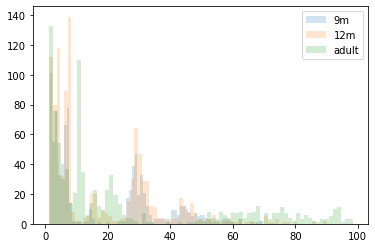

In [56]:
all_peaks_9m=[]
all_peaks_12m=[]
all_peaks_adult=[]
for s_idx, fg in enumerate(fgs_9m):
    for chan in c_chan_idx:
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_9m.extend(peaks)
        else:
            all_peaks_9m.append(peaks)
for s_idx, fg in enumerate(fgs_12m):
    for chan in c_chan_idx:
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_12m.extend(peaks)
        else:
            all_peaks_12m.append(peaks)
for s_idx, fg in enumerate(fgs_adult):
    for chan in c_chan_idx:
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_adult.extend(peaks)
        else:
            all_peaks_adult.append(peaks)
plt.hist(all_peaks_9m,75,alpha=.2,label='9m')
plt.hist(all_peaks_12m,75,alpha=.2,label='12m')
plt.hist(all_peaks_adult,75,alpha=.2,label='adult')
plt.legend()

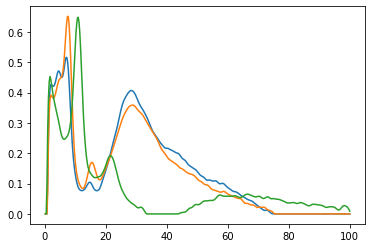

In [57]:
mean_psd_9m=np.mean(np.mean(sub_periodic_9m[:,c_chan_idx,:],axis=1),axis=0)
mean_psd_9m[mean_psd_9m<0]=0
mean_psd_12m=np.mean(np.mean(sub_periodic_12m[:,c_chan_idx,:],axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0
mean_psd_adult=np.mean(np.mean(sub_periodic_adult[:,c_chan_idx,:],axis=1),axis=0)
mean_psd_adult[mean_psd_adult<0]=0
plt.plot(freqs,mean_psd_9m)
plt.plot(freqs,mean_psd_12m)
plt.plot(freqs,mean_psd_adult)

Peak: freq=7.25, val=0.5156623990111487, width=3.5, range=5.5-9.0
Distance to nearest original peak=0.0
Peak: freq=2.0, val=0.4250734170626252, width=2.0, range=1.0-3.0
Distance to nearest original peak=0.0
Peak: freq=28.5, val=0.4064997389607199, width=14.0, range=21.5-35.5
Distance to nearest original peak=0.0
Peak: freq=4.25, val=0.38626288111796175, width=2.5, range=3.0-5.5
Distance to nearest original peak=0.25
Peak: freq=58.5, val=0.08991422120927337, width=13.5, range=51.75-65.25
Distance to nearest original peak=0.25
Peak: freq=14.5, val=0.0777840782674969, width=3.5, range=12.75-16.25
Distance to nearest original peak=0.25


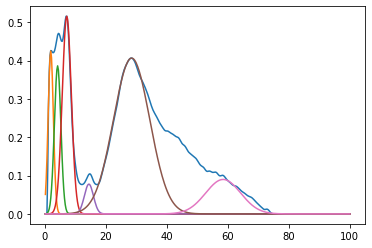

In [58]:
foi_pk_freqs_9m,foi_pk_vals_9m,foi_fwhms_9m,foi_ranges_9m=define_fois(freqs, mean_psd_9m)

Peak: freq=7.5, val=0.6513078057718616, width=3.5, range=5.75-9.25
Distance to nearest original peak=0.0
Peak: freq=2.0, val=0.3906574134246016, width=2.0, range=1.0-3.0
Distance to nearest original peak=0.0
Peak: freq=28.75, val=0.35853562105604597, width=15.5, range=21.0-36.5
Distance to nearest original peak=0.0
Peak: freq=4.25, val=0.35503827632788715, width=3.0, range=2.75-5.75
Distance to nearest original peak=2.25
Peak: freq=15.25, val=0.1245688929537941, width=3.5, range=13.5-17.0
Distance to nearest original peak=0.25
Peak: freq=59.0, val=0.044648905457306834, width=7.0, range=55.5-62.5
Distance to nearest original peak=0.25


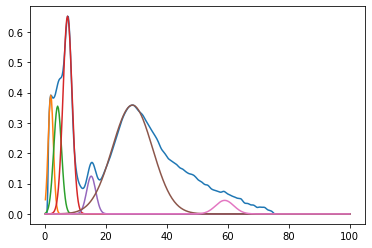

In [43]:
foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m)

Peak: freq=11.0, val=0.6476341178712238, width=3.5, range=9.25-12.75
Distance to nearest original peak=0.0
Peak: freq=1.75, val=0.45224002856338696, width=2.0, range=0.75-2.75
Distance to nearest original peak=0.0
Peak: freq=4.0, val=0.31822335152251213, width=3.0, range=2.5-5.5
Distance to nearest original peak=2.25
Peak: freq=21.5, val=0.19198173940449714, width=6.5, range=18.25-24.75
Distance to nearest original peak=0.0
Peak: freq=66.5, val=0.0650856974649142, width=31.5, range=50.75-82.25
Distance to nearest original peak=0.0


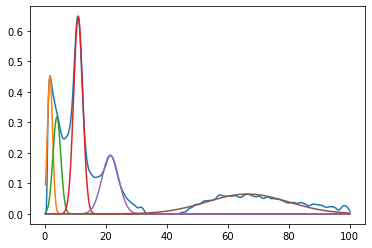

In [48]:
foi_pk_freqs_adult,foi_pk_vals_adult,foi_fwhms_adult,foi_ranges_adult=define_fois(freqs, mean_psd_adult)

In [59]:
fname = "processed_psd.mat"
output_path = op.join('/home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/',fname)
scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_psds_9m,
                     'periodic': sub_periodic_9m,
                     'aperiodic': sub_aperiodic_9m,
                     'foi_pk_freqs': foi_pk_freqs_9m,
                     'foi_pk_vals': foi_pk_vals_9m,
                     'foi_fwhms': foi_fwhms_9m,
                     'foi_ranges': foi_ranges_9m
                 })  

In [44]:
fname = "processed_psd.mat"
output_path = op.join('/home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA_behav/',fname)
scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_psds_12m,
                     'periodic': sub_periodic_12m,
                     'aperiodic': sub_aperiodic_12m,
                     'foi_pk_freqs': foi_pk_freqs_12m,
                     'foi_pk_vals': foi_pk_vals_12m,
                     'foi_fwhms': foi_fwhms_12m,
                     'foi_ranges': foi_ranges_12m
                 })  

In [49]:
fname = "processed_psd.mat"
output_path = op.join('/home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA_behav/',fname)
scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_psds_adult,
                     'periodic': sub_periodic_adult,
                     'aperiodic': sub_aperiodic_adult,
                     'foi_pk_freqs': foi_pk_freqs_adult,
                     'foi_pk_vals': foi_pk_vals_adult,
                     'foi_fwhms': foi_fwhms_adult,
                     'foi_ranges': foi_ranges_adult
                 })  

In [ ]:
foi_ranges_9m

In [ ]:
foi_ranges_12m

In [ ]:
foi_ranges_adult